### Team members

1. Amirhossein Soltani
2. Moein Taherkhani

In [57]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets


### Downloading the dataset


In [3]:

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 170498071/170498071 [01:04<00:00, 2655067.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Dataset inspection

In [4]:
print(f"# Images Train: {len(train_dataset)}")
print(f"# Images Test:  {len(test_dataset)}")

# Images Train: 50000
# Images Test:  10000


In [5]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


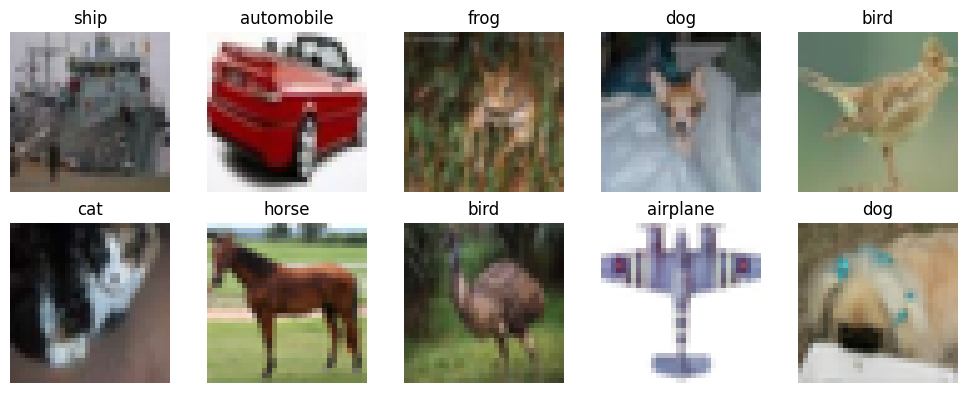

In [39]:
import matplotlib.pyplot as plt


classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

N_IMGS = 8
fig, ax = plt.subplots(2,5)
fig.set_size_inches(10, 4)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i in range(2):
    for j in range (5):
        id = np.random.randint(0,len(train_dataset),1)[0]
        img = train_dataset[id][0].numpy().transpose((1,2,0))
        ax[i,j].imshow(img)
        ax[i,j].set_title(f"{classes[train_dataset[id][1]]}")
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()


### Dataloaders

In [79]:
training_config = {'BATCH_SIZE' : 512,
                   'lr' : 2e-3,
                   'epochs' : 50
                   }


train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=True
    )

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=False,
        drop_last=True
    )

## MLP

In [66]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=3072, hidden_dim=256, output_dim=len(classes)):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


In [68]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_model = Model().to(device)

summary(mlp_model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         786,688
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 10]           2,570
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 3.01
Estimated Total Size (MB): 3.03
----------------------------------------------------------------


In [69]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=training_config['lr'])

In [76]:
log_dict = {'Training_loss' : [] ,'Validation_loss' : [] }

print("##### TRAINING ... ####")
mlp_model.train()
for epoch in range(training_config['epochs']):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)

        loss = criterion(preds, labels)
        log_dict['Training_loss'].append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Batch {i + 1}: loss {loss.item():.5f}. ")


##### TRAINING ... ####


Epoch 5 Batch 71: loss 1.36935. :  77%|███████▋  | 75/98 [00:05<00:01, 13.81it/s]


KeyboardInterrupt: 

### EVALUATION

In [78]:

print("##### EVALUATION ... ####")
mlp_model.eval()
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        imgs, labels = imgs.to(device), labels.to(device)

        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)
        
        # Just to monitor validation loss
        loss = criterion(preds, labels)
        log_dict['Validation_loss'].append(loss.item())

        pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%") 

##### EVALUATION ... ####


100%|██████████| 19/19 [00:01<00:00, 17.05it/s]

Test accuracy: 49.06%
